In [1]:
#Importing necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
data = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')

In [3]:
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [4]:
data.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [6]:
data.shape

(42, 2)

In [7]:
data.isnull().sum()

Quarter    0
Sales      0
dtype: int64

<AxesSubplot:>

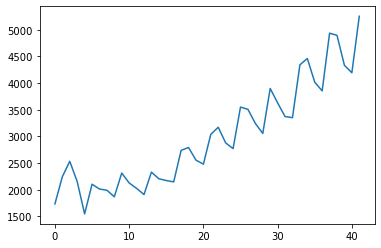

In [8]:
data.Sales.plot()

In [9]:
data['Quarters']= 0
data['Year'] = 0
for i in range(42):
    p = data["Quarter"][i]
    data['Quarters'][i]= p[0:2]
    data['Year'][i]= p[3:5]

<ipython-input-9-71bede3346bd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Quarters'][i]= p[0:2]
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-9-71bede3346bd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year'][i]= p[3:5]


In [10]:
#Dummies 
Quarters_Dummies = pd.DataFrame(pd.get_dummies(data['Quarters']))
data1 = pd.concat([data,Quarters_Dummies],axis = 1)

In [11]:
data1["t"] = np.arange(1,43)

In [12]:
data1["t_squared"] = data1["t"]*data1["t"]
data1.columns

Index(['Quarter', 'Sales', 'Quarters', 'Year', 'Q1', 'Q2', 'Q3', 'Q4', 't',
       't_squared'],
      dtype='object')

In [13]:
data1["Log_Sales"] = np.log(data1["Sales"])

<AxesSubplot:xlabel='Quarters', ylabel='Year'>

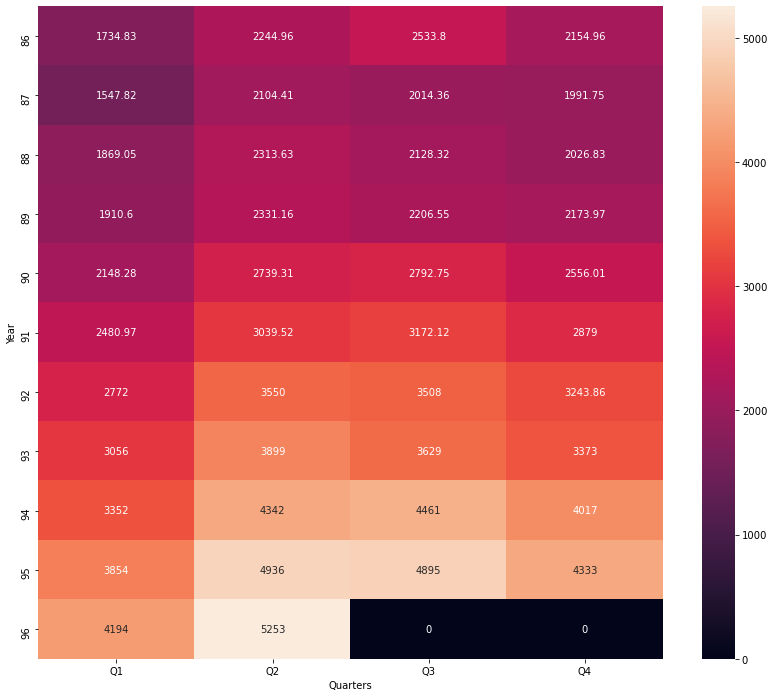

In [14]:

plt.figure(figsize=(14,12))
plot_month_y = pd.pivot_table(data = data,values="Sales",index="Year",columns="Quarters"
                             ,aggfunc="mean",fill_value=0)
sns.heatmap(plot_month_y,annot=True,fmt = "g")

<AxesSubplot:xlabel='Year', ylabel='Sales'>

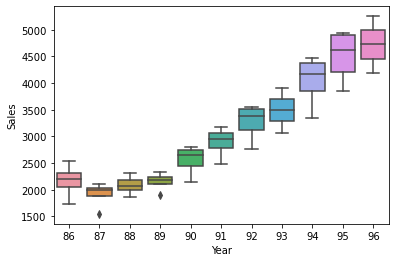

In [15]:
sns.boxplot(x = "Year",y = "Sales", data = data1)

<AxesSubplot:xlabel='Quarters', ylabel='Sales'>

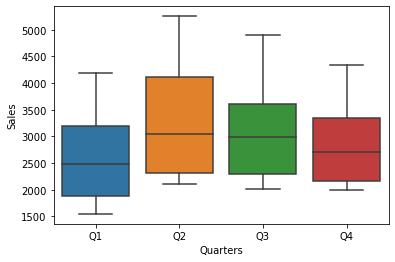

In [16]:
sns.boxplot(x = "Quarters", y = "Sales", data=data1)

In [17]:
Train = data1.head(38)
Test = data1.tail(4)

# Linear

In [18]:
import statsmodels.formula.api as smf
linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

591.553295722396

# Exponential

In [19]:
Exp = smf.ols('Log_Sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

466.24797310672255

# Quadratic

In [20]:
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

475.5618351831526

# Additive

In [21]:
add_sea = smf.ols('Sales~Q1+Q2+Q3',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1','Q2','Q3']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1860.0238154547271

# Additive Quadratic

In [22]:
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Q1','Q2','Q3','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

301.7380071934565

# Multiplicative

In [24]:
Mul_sea = smf.ols('Log_Sales~Q1+Q2+Q3',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1963.3896400779627

# Multiplicative Additive

In [25]:

Mul_Add_sea = smf.ols('Log_Sales~t+Q1+Q2+Q3',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

225.52439049816851

In [26]:
data_model = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse = pd.DataFrame(data_model)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,591.553296
1,rmse_Exp,466.247973
2,rmse_Quad,475.561835
3,rmse_add_sea,1860.023815
4,rmse_add_sea_quad,301.738007
5,rmse_Mult_sea,1963.389640
6,rmse_Mult_add_sea,225.524390


In [27]:

#Inference
#RMSE-wise, Multiplicative Additive seasonality model is the best fit